<a href="https://colab.research.google.com/github/cagBRT/Data/blob/main/Outlier_Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Do ML models make more mistakes with outliers?

Outliers are usually viewed with suspicion and are often removed. <br>

But Is this the best practice?


Sometimes, outliers are even more important than other observations. <br>

For example, the case of individuals that are outliers because they are very high-paying customers: you don’t want to discard them, if fact, you probably want to treat them with extra care.



In this notebook we try to answer the question: <br>

**Is an ML model more likely to make mistakes when making predictions on outliers?**

In [ ]:
!pip install pycaret --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.0/258.0 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.7/80.7 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 10.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 55.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.1 MB/s

In [ ]:
import numpy as np
import pandas as pd
from pycaret.datasets import get_data
from scipy.stats import percentileofscore
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.ensemble import IsolationForest
from category_encoders import CatBoostEncoder
from lightgbm import LGBMClassifier
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
DATASET_NAMES = [
  "bank",
  "blood",
  "cancer",
  "credit",
  "diabetes",
  "electrical_grid",
  "employee",
  "heart",
  "heart_disease",
  "hepatitis",
  "income",
  "juice",
  "nba",
  "wine",
  "telescope",
  "titanic",
  "us_presidential_election_results"]

In [ ]:
def get_dataset(dataset_name):
  """Get dataset."""
  target_name = datasets.loc[datasets["Dataset"]==dataset_name, "Target Variable 1"]
  df = get_data(dataset_name, verbose=False)
  X, y = df.drop(target_name, axis=1), df[target_name]
  y = y.replace({yval: binval for yval, binval in zip(y.value_counts().index, [0,1])}).iloc[:,0]
  num_features = X.columns[X.apply(is_numeric)].tolist()
  cat_features = [c for c in X.columns if c not in num_features]
  return X, y, num_features, cat_features

def is_numeric(x):
  """Check whether an object is numeric."""
  try:
    x+0
    return True
  except:
    return False

def individual_log_loss(y_true, y_pred, eps=1e-15):
  """Compute log-loss for each individual of the sample."""

  y_pred = np.clip(y_pred, eps, 1 - eps)
  return - y_true * np.log(y_pred) - (1 - y_true) * np.log(1 - y_pred)


## Case 1

Let's look at a case where a model has been trained on the dataset shown below.

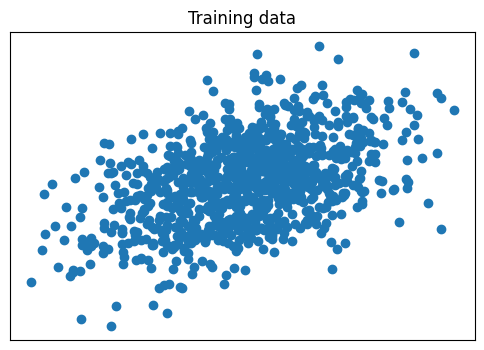

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))

x = np.random.multivariate_normal([0,0], [[1,.6],[.6,2]], size=1000)
ax.scatter(x[:,0], x[:,1])
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Training data")

fig.savefig(f"example_training.png", dpi=200, bbox_inches="tight")

**If new data is collected it can be**:
1. an outlier
2. falls within the standard range for data

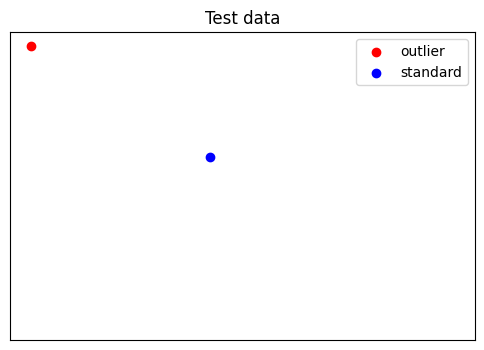

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))

ax.scatter(x[:,0], x[:,1], color="white")
ax.scatter(np.min(x, axis=0)[0], np.max(x, axis=0)[1], color="red", label="outlier")
ax.scatter(np.quantile(x, q=.3, axis=0)[0], np.quantile(x, q=.7, axis=0)[1], color="blue", label="standard")
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Test data")
ax.legend(loc="upper right")

fig.savefig(f"example_test.png", dpi=200, bbox_inches="tight")

In [ ]:
datasets = get_data(verbose=False)

In [ ]:
dataset_name = "bank"

X, y, num_features, cat_features = get_dataset(dataset_name)
X_train, X_test, y_train, y_test = train_test_split(X, y)
if len(cat_features) > 0:
    cat_encoder = CatBoostEncoder().fit(X_train[cat_features].fillna("NULL"), y_train)
    X_train[cat_features] = cat_encoder.transform(X_train[cat_features])
    X_test[cat_features] = cat_encoder.transform(X_test[cat_features])
    X_train = X_train.fillna(X_train.mean())
    X_test = X_test.fillna(X_train.mean())
iforest = IsolationForest(n_estimators = 100).fit(X_train)
iforest_scores_test = pd.Series(-iforest.score_samples(X_test), index=X_test.index)
model = LGBMClassifier(verbose=-1).fit(X_train, y_train)
pred_test = pd.Series(model.predict_proba(X_test)[:,1], index=X_test.index)
logloss_test = individual_log_loss(y_test, pred_test)

In [ ]:
X.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown


In [ ]:
id = iforest_scores_test.sort_values().tail(1).index[0]
x = X_train.apply(lambda col: percentileofscore(col, X_test.loc[id, col.name])).sort_values(key=lambda x: np.abs(50-x), ascending=False).rename("quantile") / 100

out = pd.concat([
    X.loc[id, x.index].rename("original data"),
    x
], axis=1).round(2)

out[(out["quantile"] > .95) | (out["quantile"] < .05)]

,original data,quantile
age,80,1.00
previous,13,1.00
poutcome,success,0.98
month,sep,0.98
balance,8304,0.97
job,retired,0.96


In [ ]:
pd.concat([iforest_scores_test.rename("outlierness_test"), logloss_test.rename("logloss_test")], axis=1).head()


,outlierness_test,logloss_test
35232,0.472251,0.006792
8660,0.453130,0.010784
22334,0.403048,0.013313
36785,0.429175,0.392308
34665,0.397395,0.037280


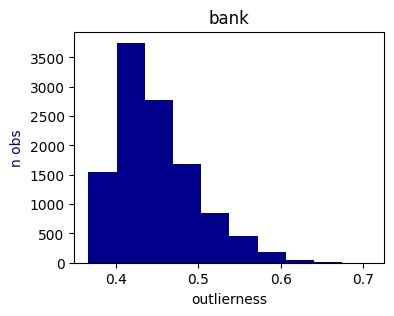

In [ ]:
fig, ax1 = plt.subplots(figsize=(4,3))

ax1.hist(iforest_scores_test, color="darkblue")

ax1.set_title(dataset_name)
ax1.set_xlabel("outlierness")
ax1.set_ylabel("n obs", color="darkblue")

fig.savefig(f"{dataset_name}_hist.png", dpi=200, bbox_inches="tight")

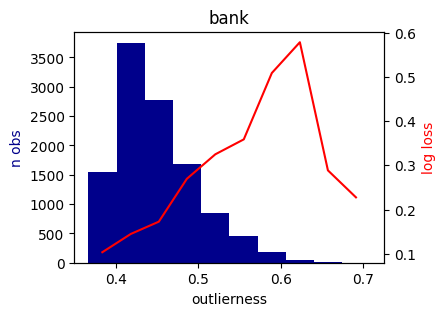

In [ ]:
cut=pd.cut(iforest_scores_test, bins=10)
logloss = logloss_test.groupby(cut).mean()

fig, ax1 = plt.subplots(figsize=(4,3))

ax2 = ax1.twinx()
ax1.hist(iforest_scores_test, color="darkblue")
ax2.plot([i.mid for i in logloss.index], logloss, color="red")

ax1.set_title(dataset_name)
ax1.set_xlabel("outlierness")
ax1.set_ylabel("n obs", color="darkblue")
ax2.set_ylabel("log loss", color="red")

fig.savefig(f"{dataset_name}_hist_logloss.png", dpi=200, bbox_inches="tight")

In [ ]:
dataset_names = []

for dataset_name in DATASET_NAMES:
    X, y, num_features, cat_features = get_dataset(dataset_name)

    if len(X) > 5000:
        dataset_names.append(dataset_name)

In [ ]:

results = []

for dataset_name in tqdm(dataset_names):
    X, y, num_features, cat_features = get_dataset(dataset_name)

    for iteration in range(5):
        X_train, X_test, y_train, y_test = train_test_split(X, y)
        if len(cat_features) > 0:
            cat_encoder = CatBoostEncoder().fit(X_train[cat_features].fillna("NULL"), y_train)
            X_train[cat_features] = cat_encoder.transform(X_train[cat_features])
            X_test[cat_features] = cat_encoder.transform(X_test[cat_features])
            X_train = X_train.fillna(X_train.mean())
            X_test = X_test.fillna(X_train.mean())
        iforest = IsolationForest(n_estimators = 100).fit(X_train)
        iforest_scores_test = pd.Series(-iforest.score_samples(X_test), index=X_test.index)
        model = LGBMClassifier(verbose=-1).fit(X_train, y_train)
        pred_test = pd.Series(model.predict_proba(X_test)[:,1], index=X_test.index)
        logloss_test = individual_log_loss(y_test, pred_test)

        iforest_q95 = iforest_scores_test.quantile(.95)
        outliers_vs_rest = (iforest_scores_test > iforest_q95).replace({True: "outliers", False: "rest"})
        logloss = logloss_test.groupby(outliers_vs_rest).mean()

        results.append({
            "dataset name": dataset_name,
            "iteration": iteration,
            "n outliers": (iforest_scores_test > iforest_q95).sum(),
            "log-loss": logloss.mean(),
            "log-loss (outliers)": logloss["outliers"],
            "log-loss (rest)": logloss["rest"]
        })

100%|██████████| 7/7 [00:28<00:00,  4.14s/it]


In [ ]:
results_agg = pd.DataFrame(results).groupby("dataset name").agg({
    "dataset name": lambda x: x.values[0],
    "iteration": lambda x: len(x),
    "n outliers": np.min,
    "log-loss": np.mean,
    "log-loss (outliers)": np.mean,
    "log-loss (rest)": np.mean,
})

results_agg["ratio"] = np.maximum(results_agg["log-loss (outliers)"], results_agg["log-loss (rest)"]) / np.minimum(results_agg["log-loss (outliers)"], results_agg["log-loss (rest)"])
results_agg = results_agg.sort_values("ratio", ascending=False)

In [ ]:
results_agg.loc[:,["log-loss","log-loss (outliers)","log-loss (rest)"]].round(3) \
    .style.apply(lambda x: ["background: red" if (v > results_agg["log-loss"].iloc[e] and x.name =="log-loss (outliers)") else ("background: lightgreen" if x.name=="log-loss (outliers)" else "") for e, v in enumerate(x)])


,log-loss,log-loss (outliers),log-loss (rest)
dataset name,,,
telescope,0.189000,0.071000,0.307000
bank,0.308000,0.434000,0.183000
wine,0.014000,0.011000,0.018000
electrical_grid,0.171000,0.193000,0.150000
income,0.264000,0.248000,0.280000
employee,0.053000,0.050000,0.056000
credit,0.423000,0.406000,0.439000
